In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting models fitted with fastNeutrino

In [2]:
def import_fastNeutrino_fit(fn):
    times = []
    functions = []
    with open(fn) as f:
        header = f.readline()
        n_anc = int(f.readline())
        for line in f:
            if line.startswith('c'):
                n, t = list(map(float, line.split()[-2:]))
                print(n,t)
            elif line.startswith('e'):
                pass
            else:
                break
        #return n_anc, params

In [72]:
chroms = ['Chr' + x for x in ['2L','2R','3L','3R']]

In [73]:
models = ['2EpochC', '2EpochE']

In [74]:
for c in chroms:
    model = import_fastNeutrino_fit('../fastNeutrino/fitted_params/{}.2EpochC.txt'.format(c))
    print(model)

758086.516 33169.7
None
772058.4796 26249.9
None
635450.7226 23552.5
None
825823.0018 46596.9
None


# numpy.piecewise

In [22]:
x = np.arange(1,100)

In [18]:
y = np.piecewise(x, [x<50, x>=50], [5,lambda x: x])

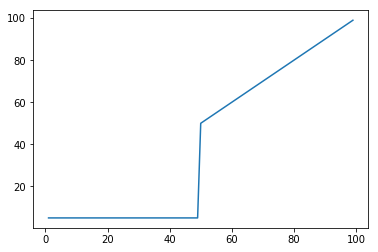

In [19]:
plt.plot(x,y)

In [11]:
z = np.piecewise(x, [10<x<50, x<80], [5,10])
plt.plot(x,z)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [31]:
f = lambda x: np.piecewise(x, [x<50, x>=50], [1, lambda v: np.exp(v/100.0)])

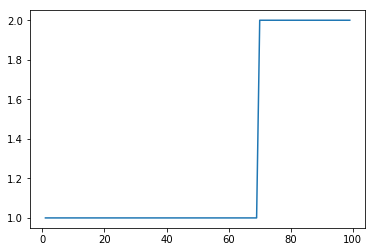

In [32]:
plt.plot(x,f(x))

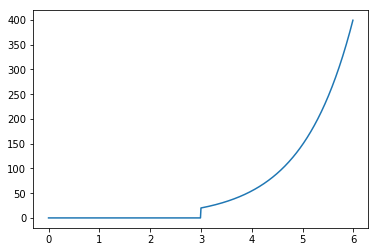

In [40]:
a = np.arange(0,6,0.01)
b = np.piecewise(a, [a<3,a>=3], [0,lambda c: np.exp(c)])
plt.plot(a,b)

In [48]:
f = lambda x: np.piecewise(x, [x>=0,x>=3,x>=5], [1,lambda c: np.exp(c), 100])

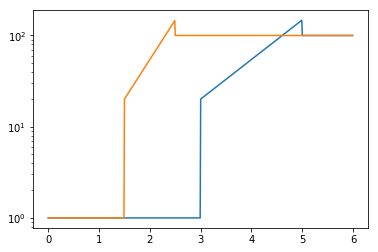

In [49]:
plt.semilogy(a,f(a))
plt.semilogy(a,f(2*a))

In [79]:
f = lambda x: np.piecewise(x, [x<=1, x<=2, x<=3, np.ones_like(x, dtype=bool)], [0, 1, 2, 3])

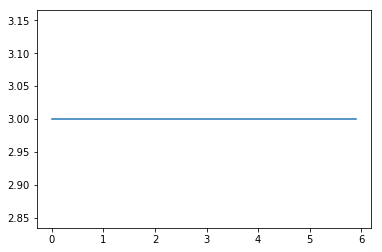

In [81]:
x = np.arange(0,6,0.1)
y = f(x)
plt.plot(x, f(x))

In [82]:
f = lambda x: np.piecewise(x, [np.ones_like(x, dtype=bool), x<=2, x<=1], [0,1,2])

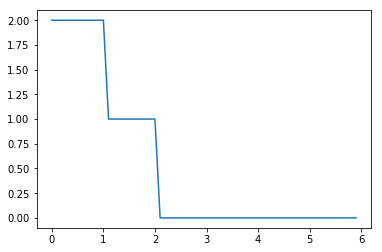

In [83]:
x = np.arange(0,6,0.1)
y = f(x)
plt.plot(x, f(x))

In [97]:
f = lambda x: np.piecewise(x, [x>=0, x>=1, x>=2], [0,1,2])

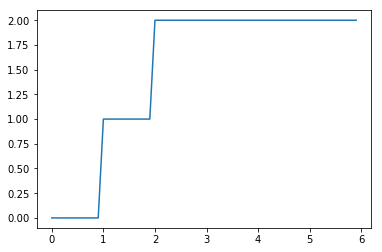

In [98]:
x = np.arange(0,6,0.1)
y = f(x)
plt.plot(x, f(x))

Model file specification:
1. First line gives the ancestral (i.e., oldest) population size.
2. Subsequent lines give demographic epochs *from most recent to most ancient*
3. Each epoch is either "c" (constant size) or "e" (exponential growth/decline).
5. "c" epochs have two parameters: $N$, the population size during the epoch; and $t$, the start time of the epoch.
6. "e" epochs have three parameters: $N$, the population size at the *end* of the epoch; $t$, the start time of the epoch; and $r$, the growth rate per generation.
7. All times are in generations.

In [64]:
class DemographicModel:
    '''Simple data structure to store fastNeutrino demographic models.'''
    
    def __init__(self):
        self.num_epochs = 0
        # Epoch start times
        self.times = []
        # Epoch final sizes
        self.sizes = []
        # Epoch growth rates
        self.rates = []
        
    def add_epoch(self, time, size, rate):
        '''Add new epoch to the demographic model. Must be added from most recent to most ancient.'''
        # WARNING: Should only add epochs from most recent to least
        self.num_epochs += 1
        self.times.append(time)
        self.sizes.append(size)
        self.rates.append(rate)

In [118]:
def import_fastNeutrino_model(model_fn):
    '''Read a fastNeutrino output file and return a DemographicModel object.'''
    
    model = DemographicModel()
    with open(model_fn) as modelfile:
        header = modelfile.readline()
        n_anc = float(modelfile.readline())
        start_time = 0.0
        
        for line in modelfile:
            if line.startswith('c'):
                n, t = map(float, line.split()[-2:])
                g = 0.0
            elif line.startswith('e'):
                n, t, g = map(float, line.split()[-3:])
            else:
                print('Warning, bad line: ' + line.strip())
                break
                
            model.add_epoch(start_time, n, g)
            start_time = t
    model.add_epoch(start_time, n_anc, 0.0)
    return model

In [119]:
test_fn = '../fastNeutrino/fitted_params/Chr2L.3EpochCE.txt'
model = import_fastNeutrino_model(test_fn)
print(model.times, model.sizes, model.rates, model.num_epochs)

[0.0, 2941.84, 47460.9] [8430405.247, 610238.9257, 300000.0] [0.000892952, 0.0, 0.0] 3


In [136]:
def exponential_growth(t, n0, t0, r):
    '''Calculate N(t) for exponentially-growing population back in time'''
    return n0*np.exp(-(t-t0)*r)
def n_t_exp(n0, t0, r):
    def h(t):
        return exponential_growth(t, n0, t0, r)
    return h

In [137]:
def n_t_pw(t, model):
    conditions = [t>=t0 for t0 in model.times]
    functions = [n_t_exp(n0, t0, r) for n0, t0, r in zip(model.sizes, model.times, model.rates)]
    return np.piecewise(t, conditions, functions)

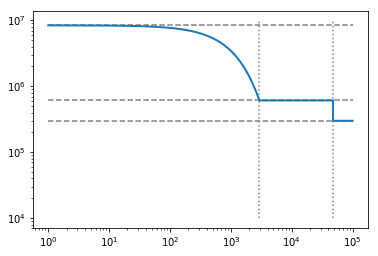

In [152]:
t = np.arange(100000)
plt.hlines(model.sizes, 1, 1e5, linestyle='dashed', color='0.5')
plt.vlines(model.times, 1e4, 1e7, linestyle='dotted', color='0.5')
plt.loglog(t, n_t_pw(t, model), lw=2)